# Classification trees

## Intro

Classification trees are one type of **decision tree** that can be used for predicting categorical outputs.
In the next notebook we will look at regression trees, which are used for making continuous predictions.

If you have ever played the game 21 questions then you already know what a classification tree is.
Or if you've ever tried to code up an artificial general intelligence using a lot of `if` statements, then you've essentially built up your own decision tree by hand.

These examples use the obvious approach of building a classifier by asking a series of yes/no questions.
The answer to each question gives you more info on class of the object until the range of possible options becomes fine enough for you to settle on a prediction.

Below is an example of such a classifier.
This one predicts the gender using the height and weight of an example person.

![](images/CARTS_example_tree.png)

The above examples however, depend on you finding the right questions to ask manually.
We'd like to be able to find the right questions to ask automatically, using machine learning.
This means that we need to start quantifying what makes a **good** split.

![](images/CARTS_geni_impurity.png)

![](images/CARTS_split_pos.png)

## Maximum depth
One hyperparameter is the max depth that we will let our tree get

Once we have fit our tree to our data, it will make classifications by evaluating which leaf of the tree a given input arrives at and classifiying it as a member of the mode (most common) class of all the other points in the dataset which are also at that leaf.

Let's build a classification tree from scratch. The first cell below just sets up some helper functions that we used previously.

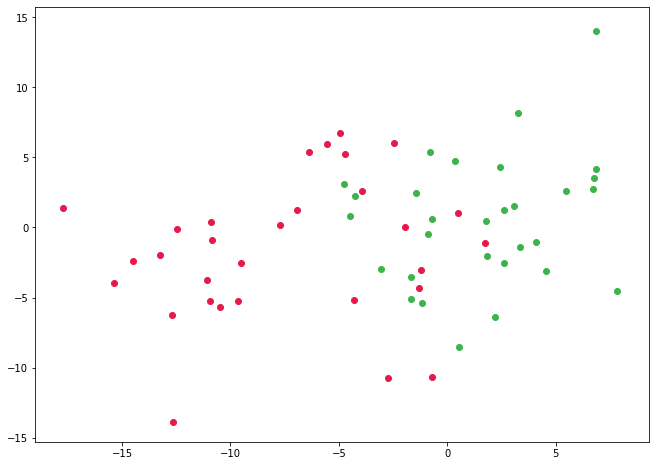

In [42]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import sklearn.datasets
from get_colors import colors

def get_data(sd=6, m=100, n_features=2, n_clusters=2):
    X, Y = sklearn.datasets.make_blobs(n_samples=m, n_features=n_features, centers=n_clusters, cluster_std=sd)
    return X, Y

def show_data(X, Y, predictions=None):
    for i in range(min(Y), max(Y)+1):
        y = Y == i
        x = X[y]
        plt.scatter(x[:, 0], x[:, 1], c=colors[i])
        if predictions is not None:
            y = predictions == i
            x = X[y]
            plt.scatter(x[:, 0], x[:, 1], c=colors[i], marker='x', s=100)
    fig = plt.gcf()
    fig.set_size_inches(11,8)
    plt.show()

def visualise_predictions(H, X, n=50):
    xmin, xmax, ymin, ymax = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
    meshgrid = np.zeros((n, n))
    for x1_idx, x1 in enumerate(np.linspace(xmin, xmax, n)): # for each column
        for x2_idx, x2 in enumerate(np.linspace(ymin, ymax, n)): # for each row
            h = H(np.array([[x1, x2]])).astype(int)[0]
            # plt.scatter(x1, x2, c=colors[h])
            # print(h)
            meshgrid[n-1-x2_idx, x1_idx] = h # axis 0 is the vertical direction starting from the top and increasing downward
        # print()

    # meshgrid[n-1, 0] = 1000
    plt.imshow(meshgrid, extent=(xmin, xmax, ymin, ymax), cmap='viridis')

m = 60
n_features = 2
n_classes = 2
X, Y = get_data(5, m, n_features, n_classes)
show_data(X, Y)

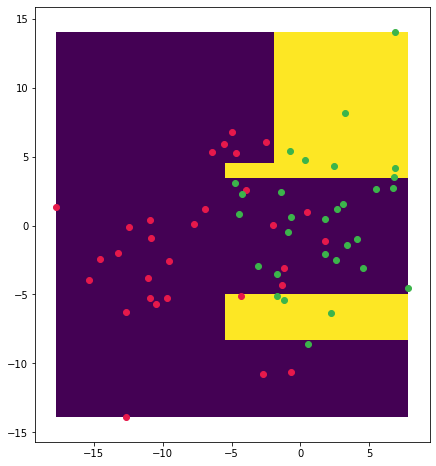

{
    "split_impurity": 0.006802721088435374,
    "feature_to_split_on": 0,
    "value_to_split_on": -5.4388212426817475,
    "positive_branch": {
        "split_impurity": 0.008928571428571428,
        "feature_to_split_on": 1,
        "value_to_split_on": -8.572478070550783,
        "positive_branch": {
            "split_impurity": 0.009861212563915268,
            "feature_to_split_on": 1,
            "value_to_split_on": -5.2354055201056084,
            "positive_branch": {
                "split_impurity": 0.182456946742661,
                "feature_to_split_on": 1,
                "value_to_split_on": 4.487449578476694,
                "positive_branch": {
                    "split_impurity": 0.0,
                    "feature_to_split_on": 0,
                    "value_to_split_on": -1.6290557297214407,
                    "positive_branch": {
                        "split_impurity": 0.0,
                        "classification": 1.0
                    },
                    

In [45]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy

class ClassificationTree:
    def __init__(self, max_depth=4):
        self.max_depth = max_depth

    def get_region_impurity(self, examples_in_region):
        x, Y = examples_in_region
        n_classes = np.ptp(Y)
        n_datapoints = len(x)
        impurity = 0
        for class_idx in range(n_classes):
            n_examples_in_class = len(x[Y == class_idx])
            p_k = n_examples_in_class / n_datapoints
            impurity += p_k * (1 - p_k)
        return impurity

    def get_split_impurity(self, x, Y, split_pos):
        in_first_region = (x[x > split_pos], Y[x > split_pos])
        proportion_in_first_region = len(in_first_region) / len(x)
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos])
        proportion_not_in_first_region = 1 - proportion_in_first_region
        impurity = 0
        impurity += proportion_in_first_region * self.get_region_impurity(in_first_region)
        impurity += proportion_not_in_first_region * self.get_region_impurity(not_in_first_region)
        return impurity

    def get_split_candidates(self, x):
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        best_feature_to_split_on = None
        best_impurity = float('inf')
        best_split_pos = None
        for feature_idx in range(n_features): # for each feature
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_impurity = self.get_best_split_on_this_feature(x, Y)
            # print('feature impurity:', split_impurity)
            if split_impurity < best_impurity:
                best_split_pos = split_pos
                best_impurity = split_impurity
                best_feature_to_split_on = feature_idx
        # print('best_split_impurity:', best_impurity)
        return best_split_pos, best_impurity, best_feature_to_split_on

    def get_best_split_on_this_feature(self, x, Y):
        split_candidates = self.get_split_candidates(x)
        best_impurity = float('inf')
        best_split_pos = None
        for split_pos in split_candidates:
            impurity = self.get_split_impurity(x, Y, split_pos)
            if impurity < best_impurity:
                best_impurity = impurity
                best_split_pos = split_pos
        return best_split_pos, best_impurity

    def extend_tree(self, X, Y, depth=0):
        split_val, split_impurity, split_feature = self.get_best_split(X, Y)
        # tree['split'] 
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            new_branch = {
                'split_impurity': 0, # so the split is pure
                'classification': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val
        positive_X = X[positive_idxs]
        positive_Y = Y[positive_idxs]
        negative_idxs = np.logical_not(positive_idxs)
        negative_X = X[negative_idxs]
        negative_Y = Y[negative_idxs]
        new_branch = {
            'split_impurity': split_impurity,
        }

        if depth < self.max_depth: # if not yet at max depth
            new_branch.update({
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1),
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1)
            })
        else:
            # print(len(Y))
            new_branch.update({'classification': np.mean(Y)})
        return new_branch

    # def get_split(self, X, Y, tree):
    #     features = X[:, tree['split']['feature_to_split_on']]
    #     idxs = features > tree['split']['value_to_split_on']
    #     return (X[idxs], Y[idxs]), (X[np.logical_not(idxs)], Y[np.logical_not(idxs)])

    def fit(self, X, Y):
        self.tree = self.extend_tree(X, Y)

    def predict(self, X):
        classifications = np.zeros(len(X))
        for idx, x in enumerate(X):
            classified = False
            tree = self.tree

            while classified == False:
                if 'classification' in tree.keys(): # if the example can be classified from this branch (we have reached a leaf)
                    classified = True
                    classifications[idx] = tree['classification']
                else: # if we need to ask further questions about the example to make splits
                    if x[tree['feature_to_split_on']] > tree['value_to_split_on']: # is the example in the positive branch
                        tree = tree['positive_branch'] # 
                    else: 
                        tree = tree['negative_branch']

        # print(classifications[:10])
        # print(classifications[-1])
        # print(np.mean(classifications))
        return classifications

    def __repr__(self):
        return json.dumps(self.tree, indent=4)

classificationTree = ClassificationTree(max_depth=5)
classificationTree.fit(X, Y)
visualise_predictions(classificationTree.predict, X)
show_data(X, Y)
print(classificationTree)


Now let's use sklearn to implement the same thing 

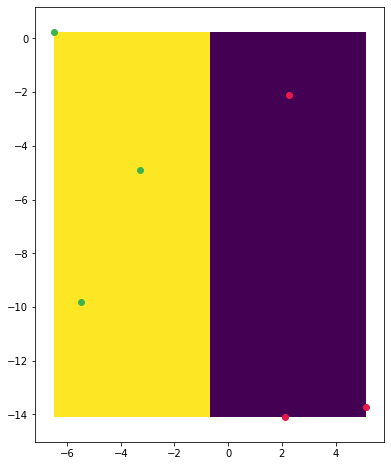

In [40]:
import sklearn.tree

classificationTree = sklearn.tree.DecisionTreeClassifier(max_depth=4)

classificationTree.fit(X, Y)
classificationTree.predict(X)
visualise_predictions(classificationTree.predict, X)
show_data(X, Y)


## sklearn hyperparameters

The classification tree has a few main hyperparameters:

### max_depth
This specifies the maximum number of questions that can be asked to split the data. It is the max number of branch splits that can be made along any route from the root to a leaf.
Any data will be able to be split perfectly if we allow it to be very deep.
How deep?
Well 
But obviously, this will lead to overfitting.
If we let this number 

[Here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is the full documentation for the sklearn classification tree.

## Classification tree limitations
- no generalisation between examples

# time complexity

## Challenges
- visualise the predictions using the above model for more than 2 classes

## Summary
- Decision trees ask multiple yes/no questions to narrow down the prediction for any input datapoint
- The best place to split the data is a measure of how "pure" the different groups that result from the split are
- Geni impurity is a measure of how pure this split is
- Geni impurity is evaluated at the midpoint between each feature value, over all of the features. The split is made at the value/feature which has the least impurity.

## Next steps
- [regression trees]()